# Overview

first implement vanilla RNN and simple SGD without the helper functions. Then use the `optim` module and run the same network with `cuda`.

### Todo:
- [ ] generate text

### Done:
- [x] get training to work
- [x] use optim and Adam

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import forward_tracer, backward_tracer, Char2Vec, num_flat_features

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from tqdm import tqdm

from IPython.display import clear_output

In [2]:
class SimpleRNN(nn.Module):
    def __init__(self, data_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(data_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        #self.h2o.register_forward_hook(forward_tracer)
        #self.h2o.register_backward_hook(backward_tracer)
        self.softmax = F.softmax
        
    def forward(self, x, hidden):
        inp = torch.cat((x, hidden), 1)
        self.hidden = self.i2h(inp)
        output = self.h2o(self.hidden.float())
        return output, self.hidden

In [ ]:
source = "";
with open('./data/shakespeare.txt', 'r') as f:
    for line in f:
        source += line + "\n"
        
source +=" " * 606
print([source[:60]])
len(source)

['First Citizen:\n\nBefore we proceed any further, hear me speak']


1156000

Epoch 3


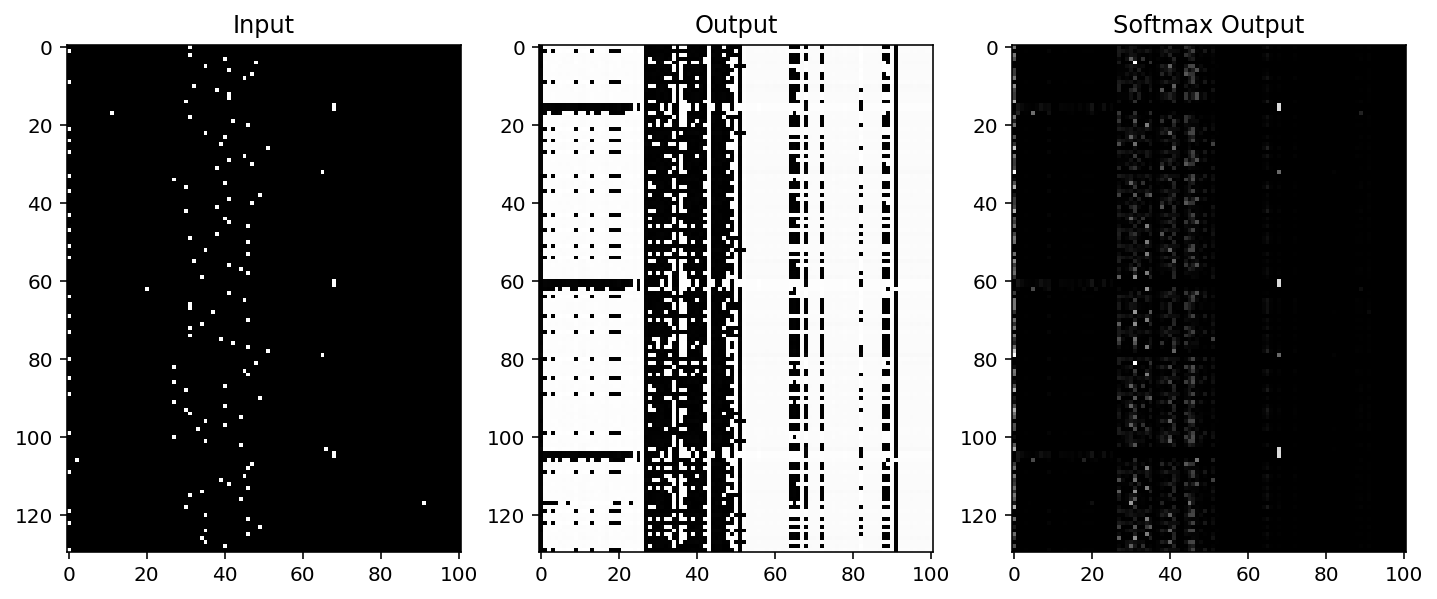

 18%|█▊        | 411/2312 [00:06<00:51, 36.95it/s]

 t denur t luu 

E ehtndte t url ttd tiurl tduhtl htnht u he

hut   ethe t eeh  tet httd titd   nd ttn 


urht euhe  d tnhtinhendte tetdhnd terle 

he


 18%|█▊        | 420/2312 [00:06<00:42, 44.17it/s]

In [ ]:
learning_rate = 1e-3
char2vec = Char2Vec()
input_size = len(char2vec.chars)
hidden_size = input_size
TIME_STEPS = 10 

model = SimpleRNN(input_size, hidden_size, input_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

seq_length = 500
batches = int(len(source)/seq_length)

for epoch_num in range(20):
    
    hidden = Variable(torch.zeros(seq_length, hidden_size))    
        
    for step in tqdm(range(batches)):

        source_ = source[step*seq_length:(step+1)*seq_length]
        input_vec = Variable(char2vec.one_hot(source_))
        target_vec = Variable(char2vec.char_code(source_[1:] + " "))
        
        hidden = hidden.detach()
        
        optimizer.zero_grad()
        loss = 0

        for t in range(TIME_STEPS):                  
            # yes! you can reuse the same network several times,
            # sum up the losses, and call backward!
            output, hidden = model(input_vec, hidden)
            loss += loss_fn(output.view(-1, input_size), target_vec)


        loss.backward()
        optimizer.step()

        for p in model.parameters():
            # print(p.grad)
            p.data -= learning_rate * p.grad.data

        if step%200 == 199:
            clear_output(wait=True)
            print('Epoch {:d}'.format(epoch_num))

            softmax_output = model.softmax(output).cpu().data.numpy()
            string_output = ''.join([char2vec.chars[row.argmax()] for row in softmax_output])

            plt.figure(figsize=(12, 9))
            plt.subplot(131)
            plt.title("Input")
            plt.imshow(input_vec.data.byte().numpy()[:130], cmap="Greys_r", interpolation="none")
            plt.subplot(132)
            plt.title("Output")
            plt.imshow(output.data.byte().numpy()[:130], cmap="Greys_r", interpolation="none")
            plt.subplot(133)
            plt.title("Softmax Output")
            plt.imshow(model.softmax(output).cpu().data.numpy()[:130], cmap="Greys_r", interpolation="none")
            plt.show()

            print(string_output[:150])

## Now use the network to generate text!

In [ ]:
from ipywidgets import widgets
from IPython.display import display

In [ ]:
def predict_next(source):
    
    clear_output()
    
    source_length = len(source)
    
    input_vec = Variable(char2vec.one_hot(source))
    hidden = Variable(torch.zeros(source_length, hidden_size))
    
    for t in range(TIME_STEPS):                  
        # yes! you can reuse the same network several times,
        # sum up the losses, and call backward!
        output, hidden = model(input_vec, hidden)
        
    softmax_output = model.softmax(output).cpu().data.numpy()
    
    string_output = ''.join([char2vec.chars[row.argmax()] for row in softmax_output])
    
    print([string_output])
    
    plt.figure(figsize=(12, 9))
    plt.subplot(131)
    plt.title("Input")
    plt.imshow(input_vec.cpu().data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(132)
    plt.title("Output")
    plt.imshow(output.cpu().data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(133)
    plt.title("Softmax Output")
    plt.imshow(softmax_output, cmap="Greys_r", interpolation="none")
    plt.show();

print(predict_next("0+0=?;"));

In [ ]:
text_input = widgets.Text()
display(text_input)

def handle_submit(sender):
    #print(text_input.value)
    predict_next(text_input.value)
    
text_input.on_submit(handle_submit)

The prediction is still not working yet.  😅